In [1]:
from base64 import decodebytes
from skimage.io import imread
from io import BytesIO
from skimage.color import rgba2rgb
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
from gramex.data import filter as gfilter
from h5py import File
from tqdm import tqdm
from matplotlib import pyplot as plt
from chart_annotation import plot_history
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

/home/jaidevd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [18]:
df = gfilter('sqlite:///data/charts_coarse.db', table='charts')

In [19]:
to_keep = df['parent_label'].value_counts()[df['parent_label'].value_counts() >= 25].index
df = df[df['parent_label'].isin(to_keep)]
df.head()

,label,validated_label,image,chart_id,is_validated,parent_label
1,populationpyramid,populationpyramid,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",9,1,barchart
6,Map,map,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",14,1,map
7,dotmatrix,dotmatrix,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",15,1,dotmatrix
8,bubble chart,scatterplot,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",16,1,bubblechartlegend
10,spiral bubble,spiral-bubble,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",18,1,bubblechartlegend


In [22]:
vc = df['parent_label'].value_counts() / df.shape[0]
vc

barchart             0.330357
map                  0.193452
bubblechartlegend    0.163690
linechart            0.136905
donut                0.101190
dotmatrix            0.074405
Name: parent_label, dtype: float64

In [23]:
vc.cumsum()

barchart             0.330357
map                  0.523810
bubblechartlegend    0.687500
linechart            0.824405
donut                0.925595
dotmatrix            1.000000
Name: parent_label, dtype: float64

In [24]:
X = np.zeros((df.shape[0], 299, 299, 3))

In [25]:
for i, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
    imgdata = row['image'].split(',')[-1]
    bytedata = decodebytes(imgdata.encode())
    image = imread(BytesIO(bytedata))
    image = rgba2rgb(image)
    image = resize(image, (299, 299), preserve_range=True)
    X[i] = image

100%|██████████| 336/336 [00:14<00:00, 23.66it/s]


In [26]:
lenc = LabelEncoder()
y = lenc.fit_transform(df['parent_label'])

In [27]:
model = Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [28]:
model.trainable = False
ip_layer = layers.Input(shape=(299, 299, 3))
x = model(ip_layer, training=False)
x = layers.Dense(df['parent_label'].nunique())(x)
outer = Model(ip_layer, x)

outer.compile(optimizer=Adam(lr=0.01),
              loss=CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])

In [29]:
y = to_categorical(y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, stratify=np.argmax(y, axis=1))

In [31]:
from tensorflow.keras.callbacks import TensorBoard

In [40]:
datagen = ImageDataGenerator(
    horizontal_flip=True, zoom_range=0.5)
datagen.fit(xtrain)
history = outer.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=len(xtrain) / 32,
    epochs=1000,
    validation_data=(xtest, ytest),
    callbacks=[EarlyStopping('val_loss', min_delta=0.01, patience=30, restore_best_weights=True),
               TensorBoard('/tmp/xception-charts-logs/')],
    verbose=0
)

In [38]:
outer.optimizer = Adam()

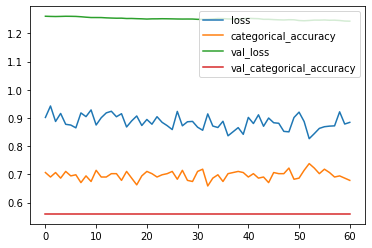

In [41]:
plot_history(history)

In [42]:
outer.save('xception-coarse.h5')

In [51]:
preds = outer.predict(X[ix]).argmax(axis=1)

In [52]:
preds

array([2, 2, 2, 4, 0, 2, 0, 0, 0, 2, 2, 2, 2, 3, 1, 1])

In [54]:
pred_labels = lenc.inverse_transform(preds)

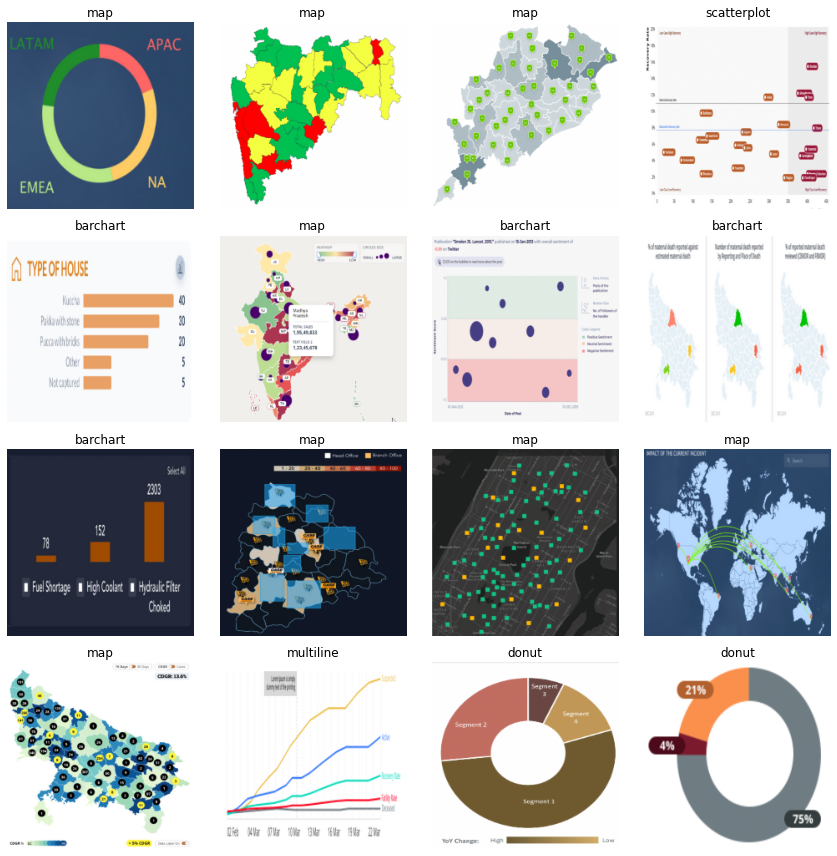

In [55]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i in range(4):
    for j in range(4):
        c = i * 4 + j
        ax[i, j].imshow(X[ix[c]])
        ax[i, j].axis('off')
        ax[i, j].set_title(pred_labels[c])
plt.tight_layout()

In [61]:
un_labels = lenc.inverse_transform(np.unique(np.argmax(y, axis=1)))

In [63]:
df[df['validated_label'].isin(un_labels)]['validated_label'].value_counts()

map            63
barchart       37
donut          25
multiline      23
scatterplot    22
Name: validated_label, dtype: int64

In [64]:
X.shape

(170, 224, 224, 3)

In [91]:
print(lenc.classes_)
lenc.transform(['multiline'])

['barchart' 'donut' 'map' 'multiline' 'scatterplot']


array([3])

In [96]:
scatterX = X[y[:, 4] == 1]

In [97]:
scatterX.shape

(22, 224, 224, 3)

In [84]:
pred = outer.predict(barchartX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
def draw_grid(data, labels, size=6, figsize=(16, 16)):
    nrows = ncols = size
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(size):
        for j in range(size):
            c = i * size + j
            try:
                ax[i, j].imshow(data[c])
                ax[i, j].axis('off')
                ax[i, j].set_title(labels[c])
            except IndexError:
                pass
    plt.tight_layout()

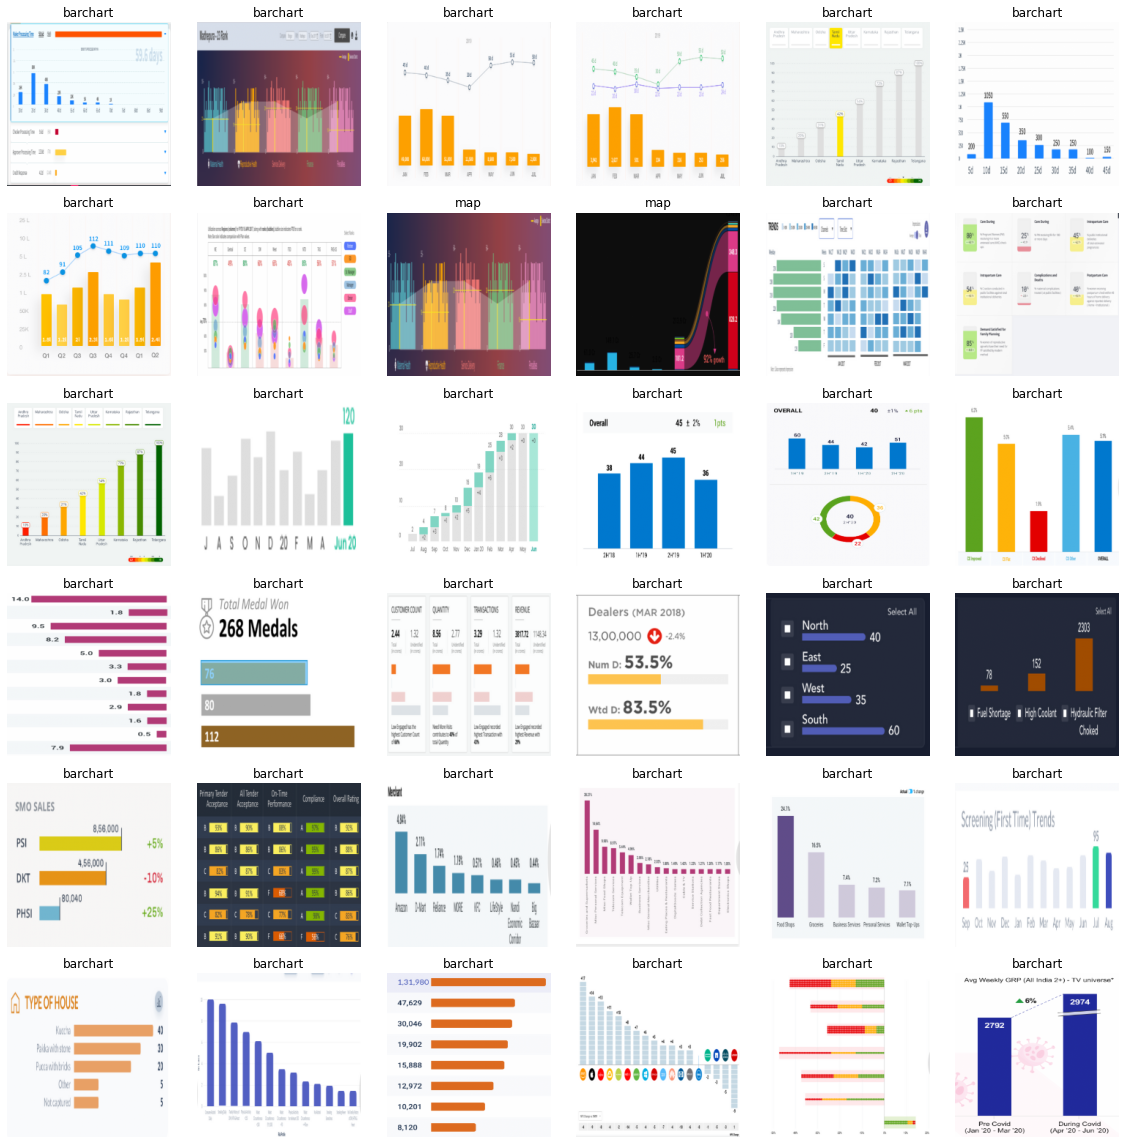

In [85]:
draw_grid(barchartX, pred_labels)

In [88]:
pred = outer.predict(donutX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)

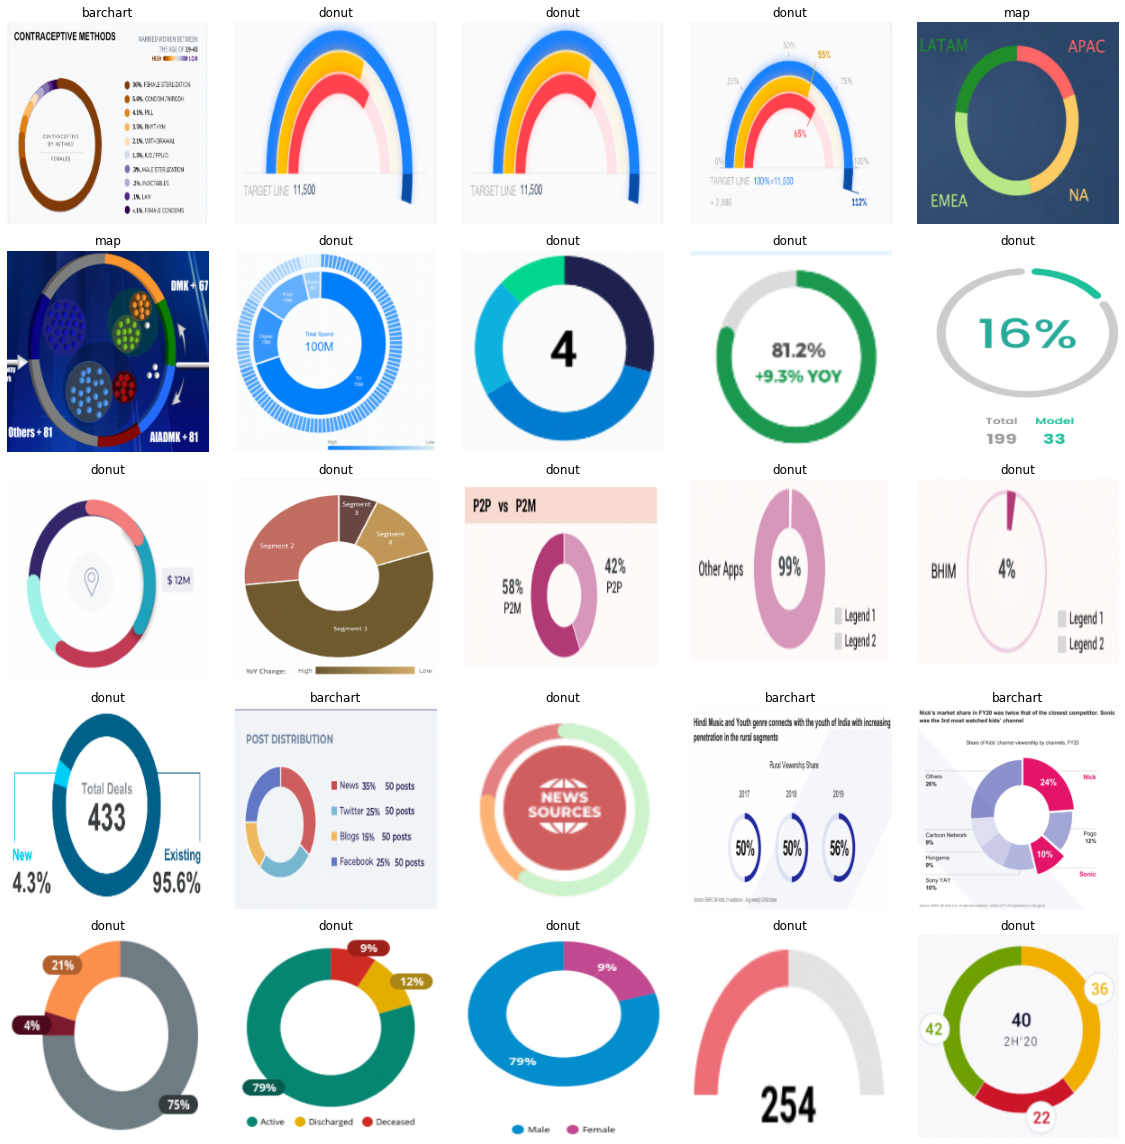

In [90]:
draw_grid(donutX, pred_labels, size=5)

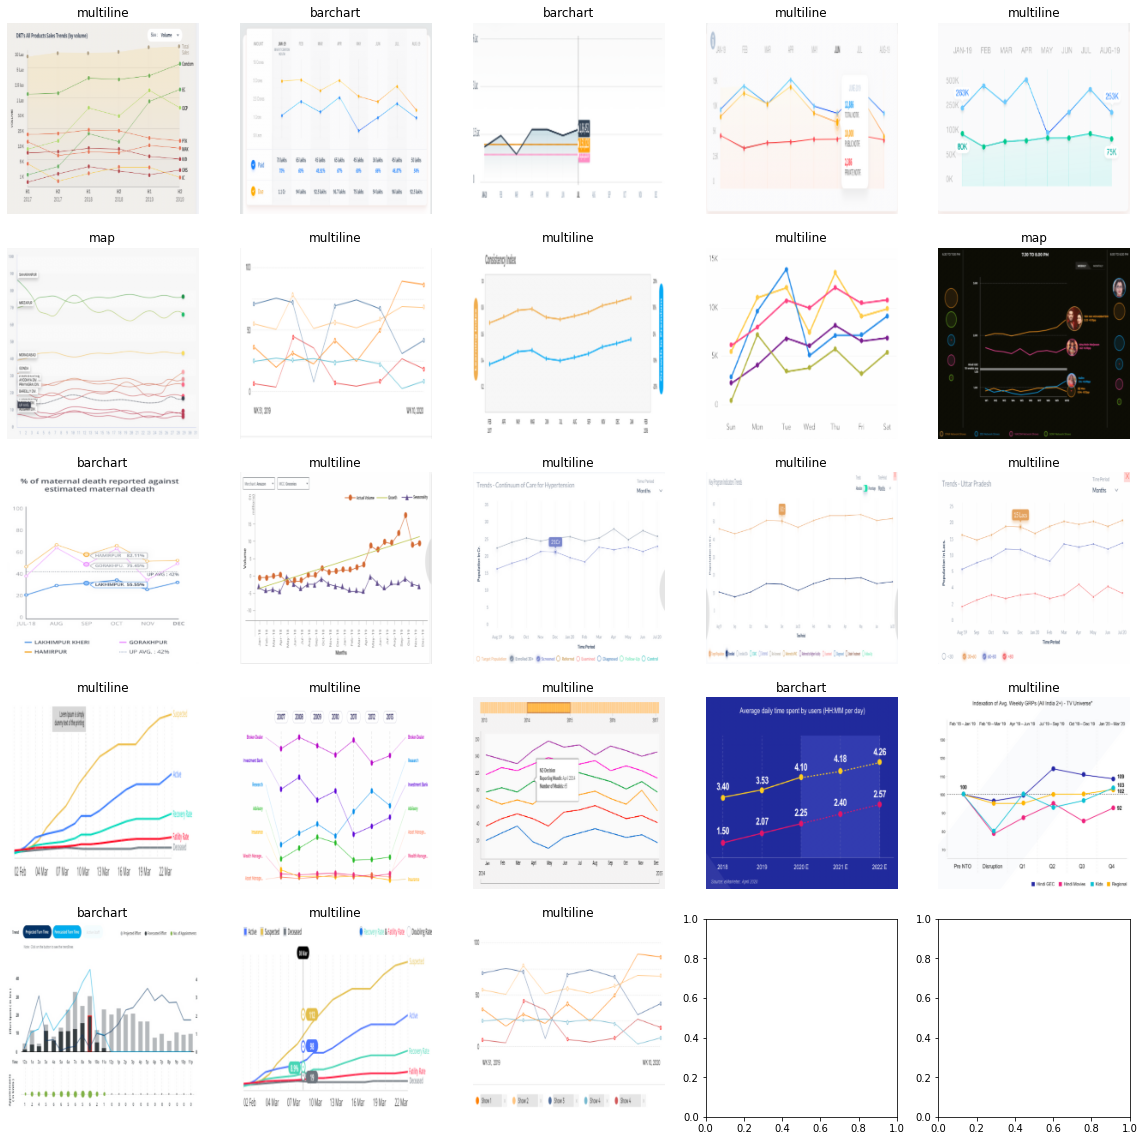

In [95]:
pred = outer.predict(multilineX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
draw_grid(multilineX, pred_labels, size=5)

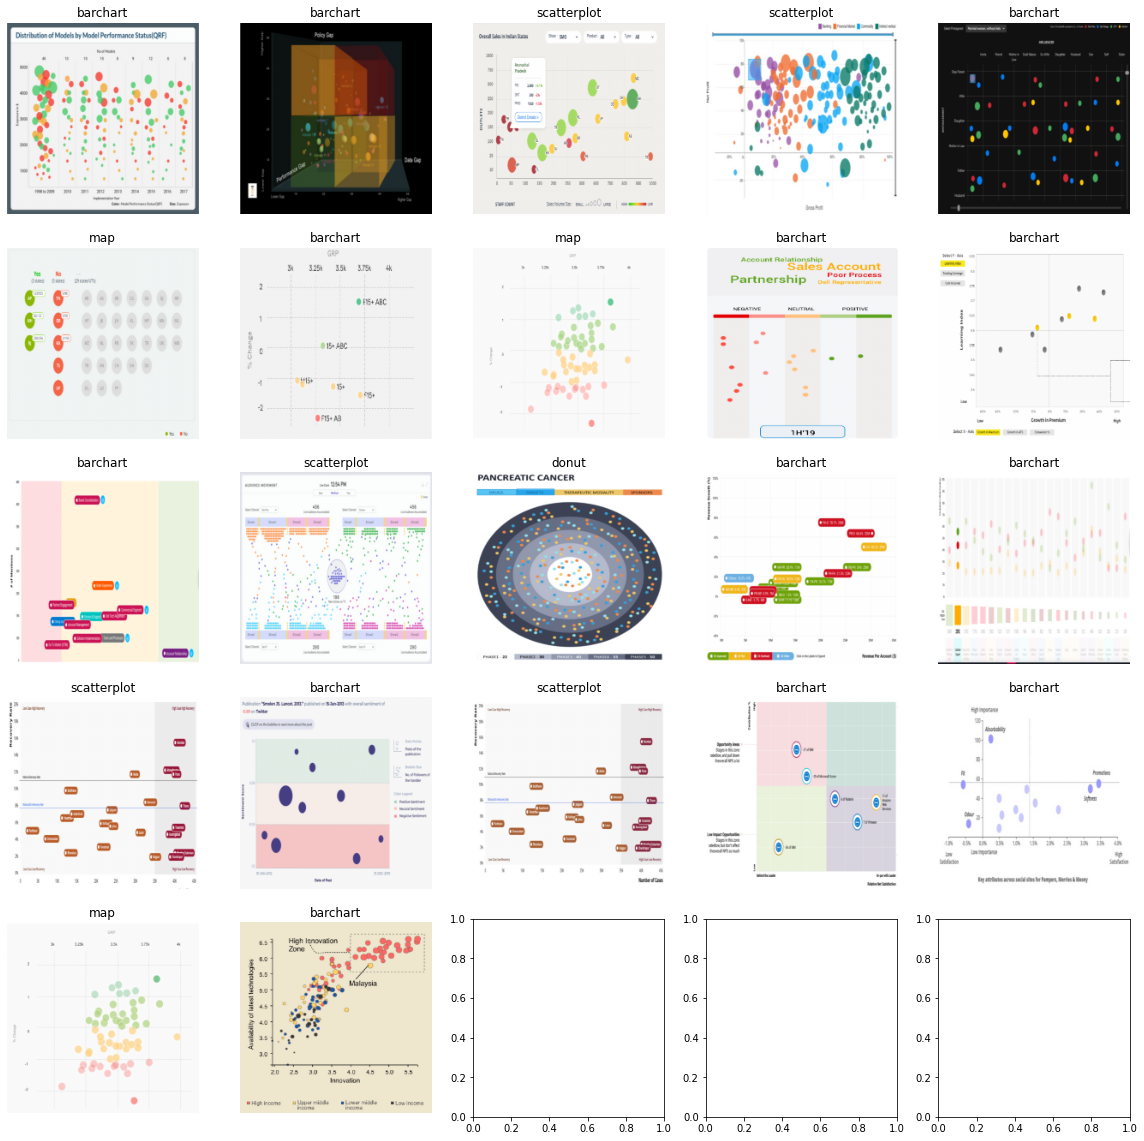

In [98]:
pred = outer.predict(scatterX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
draw_grid(scatterX, pred_labels, size=5)

In [99]:
lenc.classes_

array(['barchart', 'donut', 'map', 'multiline', 'scatterplot'],
      dtype=object)

In [101]:
outer.save('vgg16-validated-five-classes.h5')